In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"; # for GPU 1.

import pathlib
# import warnings
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

pixel = 128
batch_size = 128
epoch_size = 100

datatype = 'data-face'
modelname = 'model/face_cnn_sample_b'+str(batch_size)+'_e'+str(epoch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def createModel(target_size=(128, 128)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3),
                     input_shape=(target_size[0], target_size[1], 3)))
    model.add(Activation('relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ## leeseng: deeper block that make model training converges.
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    #
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))

    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(512, (3, 3)))
    # model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(lr=0.001),
                                     loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [3]:
def lrSchedule(epoch):
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 140:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1

    print('Learning rate:', lr)
    return lr

In [4]:
    target_size = (pixel, pixel)
    seed = 29

    tdf = pd.read_csv(datatype+'_train_set.csv')
    vdf = pd.read_csv(datatype+'_v_set.csv')
    model = createModel(target_size)

    print('model summary:', model.summary())


    filepath = modelname + ".hdf5"
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='max')

    # Log the epoch detail into csv
    csv_logger = CSVLogger(modelname + '.csv')
    # callbacks_list  = [checkpoint,csv_logger]

    LRScheduler = LearningRateScheduler(lrSchedule)
    callbacks_list = [checkpoint, csv_logger, LRScheduler]

    datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=20,
        zoom_range=0.10,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

    vdatagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        width_shift_range=0,
        height_shift_range=0,
        rotation_range=0,
        zoom_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

    train_generator = datagen.flow_from_dataframe(dataframe=tdf, x_col="filename", y_col="label",
                                                  class_mode="categorical", target_size=target_size,
                                                  shuffle=True,
                                                  batch_size=batch_size)

    valid_generator = vdatagen.flow_from_dataframe(dataframe=vdf, x_col="filename", y_col="label",
                                                   class_mode="categorical", target_size=target_size,
                                                   shuffle=True,
                                                   batch_size=batch_size)
    print(tdf)
    print(vdf)
    print(train_generator)
    print(valid_generator)
    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

    history = model.fit_generator(generator=train_generator,
                        validation_data=valid_generator,
                        epochs=epoch_size,
                        verbose=1,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_steps=STEP_SIZE_VALID,
                        callbacks=callbacks_list,
                        workers=5,
                        use_multiprocessing=True)
    # ......................................................................

    # Now the training is complete, we get
    # another object to load the weights
    # compile it, so that we can do
    # final evaluation on it
    # modelGo.load_weights(filepath)
    # modelGo.compile(loss='categorical_crossentropy',
    #                 optimizer=optimizers.Adam(lr=0.001),
    #                 metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 124, 124, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
____

29/29 [==============================] - 10s 328ms/step - loss: 5.0529e-05 - acc: 1.0000 - val_loss: 4.1769e-07 - val_acc: 1.0000
Learning rate: 0.001
Epoch 66/100
29/29 [==============================] - 10s 328ms/step - loss: 6.3471e-05 - acc: 1.0000 - val_loss: 4.5040e-07 - val_acc: 1.0000
Learning rate: 0.001
Epoch 67/100
29/29 [==============================] - 10s 338ms/step - loss: 1.8884e-05 - acc: 1.0000 - val_loss: 5.8357e-07 - val_acc: 1.0000
Learning rate: 0.001
Epoch 68/100
29/29 [==============================] - 10s 340ms/step - loss: 3.8736e-05 - acc: 1.0000 - val_loss: 3.5134e-07 - val_acc: 1.0000
Learning rate: 0.001
Epoch 69/100
29/29 [==============================] - 10s 352ms/step - loss: 3.6331e-05 - acc: 1.0000 - val_loss: 3.2386e-07 - val_acc: 1.0000
Learning rate: 0.001
Epoch 70/100
29/29 [==============================] - 10s 357ms/step - loss: 4.0327e-05 - acc: 1.0000 - val_loss: 2.2968e-07 - val_acc: 1.0000
Learning rate: 0.001
Epoch 71/100
29/29 [=========

In [5]:
model.save(modelname+'.h5')

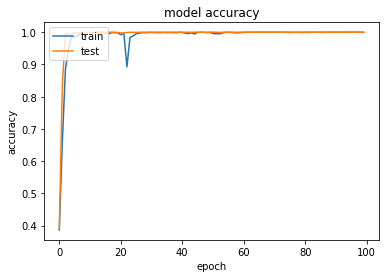

In [6]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()